DOWNLOAD DATASET

In [118]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [119]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torchtext
import re
import langid
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
train_path = "./data/data_train/train"
val_path = "./data/data_train/test"
test_path = "./data/data_test/test"

In [121]:
def get_dataframe(data_path):
    data = []
    for i,cls in enumerate(os.listdir(data_path)):
        class_path = os.path.join(data_path,cls)
        for filetxt in os.listdir(class_path):
            with open(os.path.join(class_path,filetxt),'r',encoding='utf-8') as f:
                context = f.readlines()
            context = " ".join(context)
            dt = {
                'context':context,
                'label':i
            }
            data.append(dt)
    return pd.DataFrame(data)

In [122]:
train_df = get_dataframe(train_path)
val_df = get_dataframe(val_path)
test_df = get_dataframe(test_path)

In [123]:
### Check language
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["context"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [124]:
train_df_vi, train_df_other = identify_vn(train_df)
val_df_vi, val_df_other = identify_vn(val_df)
test_df_vi, test_df_other = identify_vn(test_df)

In [125]:
### Preprocess data
import re
import string

def preprocess_text(text):

    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

In [126]:
train_df_vi['preprocess_context'] = [preprocess_text(context) for context in train_df_vi['context']]
val_df_vi['preprocess_context'] = [preprocess_text(context) for context in val_df_vi['context']]
test_df_vi['preprocess_context'] = [preprocess_text(context) for context in test_df_vi['context']]

<ipython-input-126-b1bd95c9c316>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_context'] = [preprocess_text(context) for context in train_df_vi['context']]
<ipython-input-126-b1bd95c9c316>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_vi['preprocess_context'] = [preprocess_text(context) for context in val_df_vi['context']]
<ipython-input-126-b1bd95c9c316>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

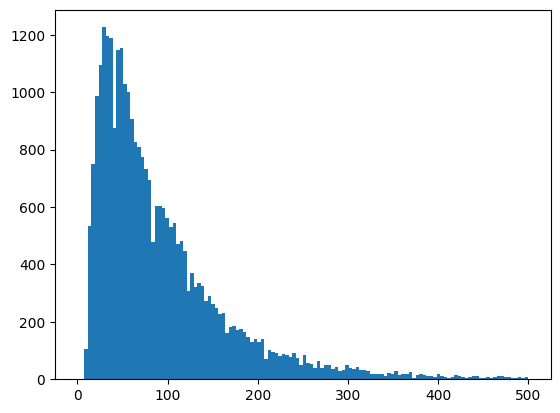

In [127]:
import matplotlib.pyplot as plt

plt.hist([len(context.split()) for context in train_df_vi['preprocess_context']], bins=128, range=(0, 500))
plt.show()

TOKENIZING

In [128]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')
print(example)
print(tokenizer(example))

In [129]:
def yield_tokens(contexts, tokenizer):
    for context in contexts:
        yield tokenizer(context)

In [130]:
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_context'], tokenizer),
    max_tokens=vocab_size,
    specials=["<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [131]:
dict = (vocabulary.get_stoi())
sorted_dict = sorted(dict.items(), key=lambda x:x[1])
print(sorted_dict)


[('<unk>', 0), ('ăn', 1), ('mình', 2), ('có', 3), ('là', 4), ('không', 5), ('quán', 6), ('thì', 7), ('và', 8), ('cũng', 9), ('ngon', 10), ('́', 11), ('rất', 12), ('k', 13), ('̀', 14), ('mà', 15), ('nhưng', 16), ('nên', 17), ('ở', 18), ('đây', 19), ('lại', 20), ('món', 21), ('đi', 22), ('thấy', 23), ('viên', 24), ('ko', 25), ('nhân', 26), ('được', 27), ('như', 28), ('với', 29), ('giá', 30), ('bánh', 31), ('cho', 32), ('bạn', 33), ('ra', 34), ('này', 35), ('̣', 36), ('đến', 37), ('nói', 38), ('vụ', 39), ('lần', 40), ('quá', 41), ('khá', 42), ('uống', 43), ('còn', 44), ('đồ', 45), ('nhiều', 46), ('phục', 47), ('nước', 48), ('cả', 49), ('hơi', 50), ('phải', 51), ('vị', 52), ('của', 53), ('vào', 54), ('cái', 55), ('nữa', 56), ('thích', 57), ('luôn', 58), ('gian', 59), ('khách', 60), ('gọi', 61), ('mới', 62), ('người', 63), ('các', 64), ('rồi', 65), ('lắm', 66), ('để', 67), ('sẽ', 68), ('chỉ', 69), ('n', 70), ('vì', 71), ('trong', 72), ('trà', 73), ('i', 74), ('gì', 75), ('hơn', 76), ('nào',

In [132]:
print(example)
print((tokenizer(example)))
print(vocabulary(tokenizer(example)))

nhìn chung wán trang trí đẹp nhưg bị khuất nhân viên thì có vài ng nhiệt tình vài ng thì thấy khó chịu món đá bào thì ok
['nhìn', 'chung', 'wán', 'trang', 'trí', 'đẹp', 'nhưg', 'bị', 'khuất', 'nhân', 'viên', 'thì', 'có', 'vài', 'ng', 'nhiệt', 'tình', 'vài', 'ng', 'thì', 'thấy', 'khó', 'chịu', 'món', 'đá', 'bào', 'thì', 'ok']
[106, 114, 1845, 227, 158, 93, 1214, 116, 1484, 26, 24, 7, 3, 347, 81, 145, 100, 347, 81, 7, 23, 231, 285, 21, 258, 1023, 7, 193]


PREPARE DATASET

In [133]:
def prepare_dataset(df):
    labels = df['label']
    contexts = df['preprocess_context']
    for context,label in zip(contexts,labels):
        yield vocabulary(tokenizer(context)),label

In [134]:
from torchtext.data.functional import to_map_style_dataset

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

val_dataset = prepare_dataset(val_df_vi)
val_dataset = to_map_style_dataset(val_dataset)


In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    encoded_contexts,labels,offsets = [],[],[0]
    for encoded_context,label in batch:
        labels.append(label)
        encoded_context = torch.tensor(encoded_context,dtype = torch.int64)
        encoded_contexts.append(encoded_context)
        offsets.append(encoded_context.size(0))


    labels = torch.tensor(labels,dtype = torch.int64)
    encoded_contexts = torch.cat(encoded_contexts)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return encoded_contexts.to(device),offsets.to(device),labels.to(device)

In [139]:
from torch.utils.data import DataLoader
batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_batch
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_batch
)

In [140]:
len(train_dataloader),len(val_dataloader)

(233, 78)

BUILD MODEL WITH EMBEDDING LAYER AND EMBEDDINGBAG LAYER(MAIN)

In [142]:
from torch import nn
class TextClassificationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim,num_class,seq_length):
        super(TextClassificationModel, self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        self.ft = nn.Flatten()
        self.linear = nn.Linear(embed_dim*seq_length,num_class)

    def forward(self,input):
        x = self.linear(self.ft(self.embed(input)))
        return x

In [143]:
batch_size = 5
seq_length = 10
input = torch.ones([batch_size, seq_length], dtype=torch.int32)
model = TextClassificationModel(5000, 100, 2, seq_length)
output = model(input)
output

tensor([[0.0991, 0.4864],
        [0.0991, 0.4864],
        [0.0991, 0.4864],
        [0.0991, 0.4864],
        [0.0991, 0.4864]], grad_fn=<AddmmBackward0>)

In [144]:
model

TextClassificationModel(
  (embed): Embedding(5000, 100)
  (ft): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1000, out_features=2, bias=True)
)

In [145]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.fc(embedded)

In [146]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

In [147]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(10000, 100, mode='mean')
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [148]:
encoded_sentences, offsets, labels = next(iter(train_dataloader))

In [149]:
predictions = model(encoded_sentences, offsets)

In [150]:
predictions.shape

torch.Size([128, 2])

TRAINING

In [151]:
learning_rate = 2e-5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [152]:
loss = criterion(predictions, labels)

In [153]:
loss

tensor(0.7180, grad_fn=<NllLossBackward0>)

In [161]:
import time

def train(model, optimizer, criterion, train_dataloader, epoch=0, log_interval=50):
    model.train()
    log_acc, log_count,epoch_acc,epoch_count = 0, 0, 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, offsets, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model(inputs, offsets)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        log_acc += (predictions.argmax(1) == labels).sum().item()
        log_count += labels.size(0)
        epoch_acc += (predictions.argmax(1) == labels).sum().item()
        epoch_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), log_acc / log_count
                )
            )
            log_acc, log_count = 0, 0
            start_time = time.time()

    total_epoch_acc = epoch_acc / epoch_count
    mean_epoch_loss = sum(losses) / len(losses)
    return total_epoch_acc, mean_epoch_loss

In [162]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader)

| epoch   0 |    50/  233 batches | accuracy    0.496
| epoch   0 |   100/  233 batches | accuracy    0.497
| epoch   0 |   150/  233 batches | accuracy    0.485
| epoch   0 |   200/  233 batches | accuracy    0.505


In [164]:
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    epoch_acc, epoch_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, offsets, labels) in enumerate(valid_dataloader):
            predictions = model(inputs, offsets)
            loss = criterion(predictions, labels)
            losses.append(loss)
            epoch_acc += (predictions.argmax(1) == labels).sum().item()
            epoch_count += labels.size(0)

    total_epoch_acc = epoch_acc / epoch_count
    mean_epoch_loss = sum(losses) / len(losses)
    return total_epoch_acc, mean_epoch_loss

In [165]:
eval_acc, eval_loss = evaluate(model, criterion, val_dataloader)

In [166]:
eval_acc, eval_loss

(0.491180324564056, tensor(0.6974))

In [167]:
# Saved models path
save_path = "saved_models"
os.makedirs(save_path,exist_ok = True)

In [168]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)
learning_rate = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
min_val_loss = 999
num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, epoch)
    eval_acc, eval_loss = evaluate(model, criterion, val_dataloader)
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)
    checkpoint = {
            "model": model.state_dict(),
            "epoch": epoch + 1,
            "best_val_acc": eval_acc,
            "optimizer": optimizer.state_dict()
        }
    if(eval_loss<min_val_loss):
      torch.save(checkpoint,os.path.join(save_path,'best.pt'))
    torch.save(checkpoint,os.path.join(save_path,'last.pt'))

| epoch   1 |    50/  233 batches | accuracy    0.659
| epoch   1 |   100/  233 batches | accuracy    0.800
| epoch   1 |   150/  233 batches | accuracy    0.826
| epoch   1 |   200/  233 batches | accuracy    0.838
-----------------------------------------------------------
| End of epoch   1 | Time:  2.54s | Train Accuracy    0.790 | Train Loss    0.459 | Valid Accuracy    0.849 | Valid Loss    0.385 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.853
| epoch   2 |   100/  233 batches | accuracy    0.851
| epoch   2 |   150/  233 batches | accuracy    0.865
| epoch   2 |   200/  233 batches | accuracy    0.858
-----------------------------------------------------------
| End of epoch   2 | Time:  3.14s | Train Accuracy    0.859 | Train Loss    0.360 | Valid Accuracy    0.865 | Valid Loss    0.355 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.872
| epoch   3 

In [169]:
# Load best model
ckp = torch.load(os.path.join(save_path,'best.pt'))
model.load_state_dict(ckp['model'])

<All keys matched successfully>

Evaluate on test dataset

In [170]:
def predict(text):
    with torch.no_grad():
        encoded = torch.tensor(vocabulary(tokenizer(text)))
        output = model(encoded, torch.tensor([0]))
        return output.argmax(1).item()

In [171]:
preds = test_df_vi['preprocess_context'].apply(predict)

In [172]:
sum(preds==test_df_vi['label'])/len(test_df_vi)

0.8788306451612903

Compare with BOW and TF-IDF using Logistic Regression

In [177]:
train_contexts = np.array(train_df_vi['context'].tolist())
train_labels = np.array(train_df_vi['label'].tolist())
test_contexts = np.array(test_df['context'].tolist())
test_labels = np.array(test_df['label'].tolist())

BOW


In [178]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 10000)
train_bow = vectorizer.fit_transform(train_contexts)
test_bow = vectorizer.transform(test_contexts)

In [179]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [180]:
lr.fit(train_bow,train_labels)
lr.score(test_bow,test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8773

TF-IDF

In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features = 10000)

In [182]:
train_tfidf = tfidf_vectorizer.fit_transform(train_contexts)
test_tfidf = tfidf_vectorizer.transform(test_contexts)

In [183]:
tfidf_lr = LogisticRegression()

In [184]:
tfidf_lr.fit(train_tfidf,train_labels)
tfidf_lr.score(test_tfidf,test_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8859